# 🌿 Plant Disease Classification — Custom CNN (Full)

This notebook is designed to run in a **local web Jupyter Notebook** (Anaconda/JupyterLab/Jupyter Notebook) on Windows 10.

**Mode:** Full

**Model:** Custom lightweight CNN (built from scratch) — simpler and faster to train on CPU.

---

### Notes before running
1. Install required packages if missing: `pip install tensorflow opendatasets matplotlib seaborn scikit-learn`
2. For automatic Kaggle download via `opendatasets`, place your `kaggle.json` at `~/.kaggle/kaggle.json`.
   - If you don't want to use the Kaggle API, download the dataset manually from Kaggle and extract to `plantdisease/PlantVillage`.
3. Run cells from top to bottom. Adjust `max_images_per_class` and `IMG_SIZE` for speed/accuracy tradeoffs.


In [1]:
# === Configuration ===
USE_SUBSET = False
max_images_per_class = 120  # reduce to 50 for even faster runs
random_seed = 42

DATA_ROOT = 'plantdisease'
ORIG_DATA_DIR = DATA_ROOT + '/PlantVillage'
WORK_DIR = 'plantdisease/working'
SPLIT_ROOT = WORK_DIR + '/split' 
TRAIN_DIR = SPLIT_ROOT + '/train'
VAL_DIR = SPLIT_ROOT + '/valid'
TEST_DIR  = SPLIT_ROOT + '/test'

print('Subset mode:', USE_SUBSET)
print('Max images per class:', max_images_per_class)

Subset mode: False
Max images per class: 120


In [2]:
# Uncomment the pip install line if you need to install packages
#!pip install tensorflow opendatasets matplotlib seaborn scikit-learn

In [3]:
# === Install / Import Dependencies ===
import os
import shutil
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import opendatasets as od
import random
import shutil
from sklearn.model_selection import train_test_split

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
random.seed(random_seed)
np.random.seed(random_seed)
print('TensorFlow version:', tf.__version__)
Path(DATA_ROOT).mkdir(parents=True, exist_ok=True)
print('Data root folder:', DATA_ROOT)

TensorFlow version: 2.20.0
Data root folder: plantdisease


In [4]:
# === Full Dataset Setup: PlantVillage ===

# === Step 1: Download full dataset from Kaggle ===
# Source: https://www.kaggle.com/datasets/emmarex/plantdisease
# Show sample folders
if Path(DATA_ROOT).exists():
    sample = list(Path(DATA_ROOT).iterdir())[:8]
    print('Sample classes:', [p.name for p in sample])
else:
    print('Dataset not available yet. After placing the dataset, re-run this cell.')
    
# If you already downloaded the dataset, this will be skipped.
if not Path(ORIG_DATA_DIR).exists():
    print('Attempting to download PlantVillage from Kaggle via opendatasets...')
    try:
        od.download('https://www.kaggle.com/datasets/emmarex/plantdisease')
        print('Downloaded. Check folder:', DATA_ROOT)
    except Exception as e:
        print('Download failed or Kaggle not configured. Please manually download and extract to:', DATA_ROOT)
        print('Error:', e)
else:
    print('Found dataset at', DATA_ROOT)



Sample classes: ['PlantVillage', 'split', 'working']
Found dataset at plantdisease


In [5]:
for folder in os.listdir(ORIG_DATA_DIR):
    folder_path = os.path.join(ORIG_DATA_DIR, folder)
    if os.path.isdir(folder_path):
        print(f"{folder}: {len(os.listdir(folder_path))} images")

Pepper__bell___Bacterial_spot: 997 images
Pepper__bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___healthy: 152 images
Potato___Late_blight: 1000 images
Tomato_Bacterial_spot: 2127 images
Tomato_Early_blight: 1000 images
Tomato_healthy: 1591 images
Tomato_Late_blight: 1909 images
Tomato_Leaf_Mold: 952 images
Tomato_Septoria_leaf_spot: 1771 images
Tomato_Spider_mites_Two_spotted_spider_mite: 1676 images
Tomato__Target_Spot: 1404 images
Tomato__Tomato_mosaic_virus: 373 images
Tomato__Tomato_YellowLeaf__Curl_Virus: 3209 images


In [8]:
# === Step 2: Split Dataset into test, validation and train sets ===

for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
    os.makedirs(d, exist_ok=True)
    
for cls in sorted(os.listdir(ORIG_DATA_DIR)):
    src_cls_dir = os.path.join(ORIG_DATA_DIR, cls)
    
    if not os.path.isdir(src_cls_dir):
        continue
        
    imgs = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    
    if len(imgs) == 0:
        continue
        
    train_imgs, temp_imgs = train_test_split(imgs, test_size=0.30, random_state=42)
    val_imgs, test_imgs   = train_test_split(temp_imgs, test_size=0.50, random_state=42)

    for split_name, img_list in zip([TRAIN_DIR, VAL_DIR, TEST_DIR], [train_imgs, val_imgs, test_imgs]):
        dst_cls_dir = os.path.join(split_name, cls)
        os.makedirs(dst_cls_dir, exist_ok=True)
        
        for im in img_list:
            src = os.path.join(src_cls_dir, im)
            dst = os.path.join(dst_cls_dir, im)
            shutil.copy2(src, dst)
            
def count_images(path):
    total=0
    
    for root, dirs, files in os.walk(path):
        total += sum(1 for f in files if f.lower().endswith(('.jpg','.jpeg','.png')))
        
    return total

print("Train Images: ", count_images(TRAIN_DIR))
print("Val   Images: ", count_images(VAL_DIR))
print("Test  Images: ", count_images(TEST_DIR))

Train Images:  14440
Val   Images:  3097
Test  Images:  3101


In [13]:
# === Step 3: Increase datasize with existing images ===

IMG_SIZE = (128, 128)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_val_datagen = ImageDataGenerator(rescale=1./255)
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)
val_gen = test_val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = test_val_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 14440 images belonging to 15 classes.
Found 3097 images belonging to 15 classes.
Found 3101 images belonging to 15 classes.


In [14]:
class_labels = list(train_gen.class_indices.keys())
print('Found classes:', len(class_labels))

Found classes: 15


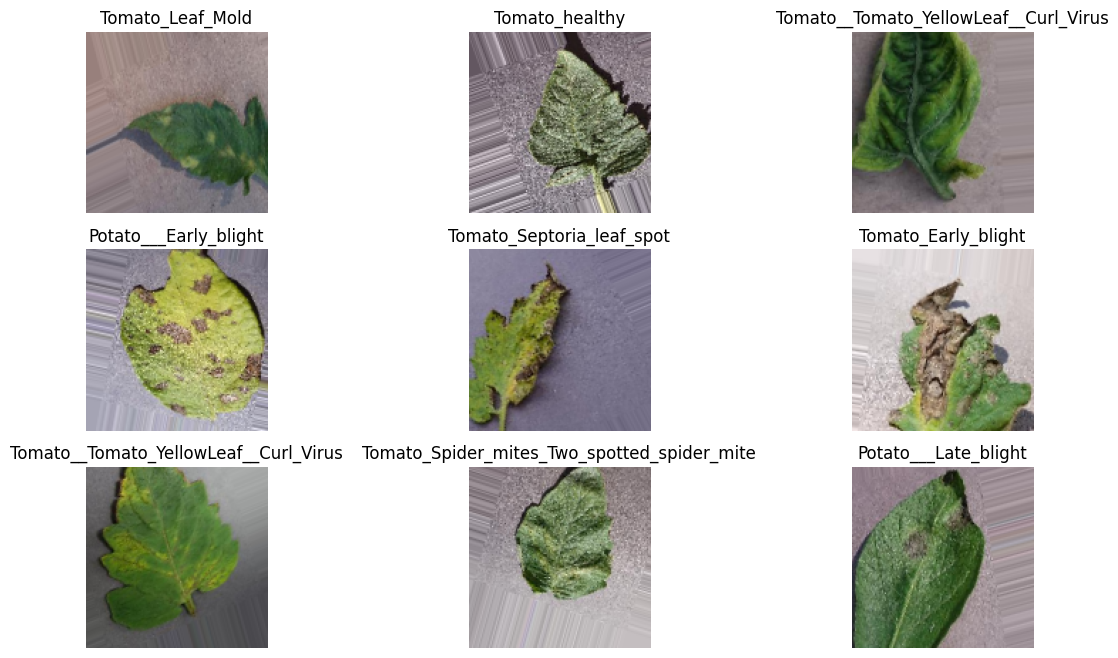

In [15]:
x,y = next(train_gen)
plt.figure(figsize=(14,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(x[i])
    label_idx = np.argmax(y[i])
    label = list(train_gen.class_indices.keys())[label_idx]
    plt.title(label)
    plt.axis('off')
plt.show()

In [16]:
# === Build Custom CNN ===
num_classes = len(class_labels)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 15)                  │           3,855 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,520,783 (24.87 MB)

 Trainable params: 6,520,335 (24.87 MB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
# === Train model ===
EPOCHS = 10
es = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
chk = ModelCheckpoint('best_custom_cnn.keras', save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
)

print('Training complete')

Epoch 1/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 398s 879ms/step - accuracy: 0.5644 - loss: 1.3290 - val_accuracy: 0.4227 - val_loss: 2.2164
Epoch 2/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 492s 990ms/step - accuracy: 0.5821 - loss: 1.2704 - val_accuracy: 0.5069 - val_loss: 2.7551
Epoch 3/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - accuracy: 0.6035 - loss: 1.1997 - val_accuracy: 0.3943 - val_loss: 3.4595
Epoch 4/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 466s 1s/step - accuracy: 0.6268 - loss: 1.1292 - val_accuracy: 0.3093 - val_loss: 4.0480
Epoch 5/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 452s 1000ms/step - accuracy: 0.6482 - loss: 1.0592 - val_accuracy: 0.4372 - val_loss: 12.8698
Epoch 6/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 451s 997ms/step - accuracy: 0.6717 - loss: 1.0171 - val_accuracy: 0.2564 - val_loss: 16.8889
Epoch 7/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 453s 1s/step - accuracy: 0.6875 - loss: 0.9625 - val_accuracy: 0.7142 - val_loss: 0.9552
Epoch 8/10
452/452 ━━━━━━━━━━━━━━━━━━━━ 455s 1s/step - accuracy: 0.6971 - loss: 0.

97/97 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.4039 - loss: 8.8880
Validation accuracy: 0.4039
97/97 ━━━━━━━━━━━━━━━━━━━━ 18s 181ms/step

Classification Report:

                                             precision    recall  f1-score   support

              Pepper__bell___Bacterial_spot       0.20      0.19      0.20       150
                     Pepper__bell___healthy       0.65      0.54      0.59       222
                      Potato___Early_blight       0.23      0.99      0.37       150
                       Potato___Late_blight       0.44      0.17      0.25       150
                           Potato___healthy       0.00      0.00      0.00        23
                      Tomato_Bacterial_spot       0.77      0.80      0.79       319
                        Tomato_Early_blight       0.38      0.23      0.28       150
                         Tomato_Late_blight       0.25      0.53      0.34       286
                           Tomato_Leaf_Mold       0.64      0.1

C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Eastwood\anaconda3\envs\plantdl\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

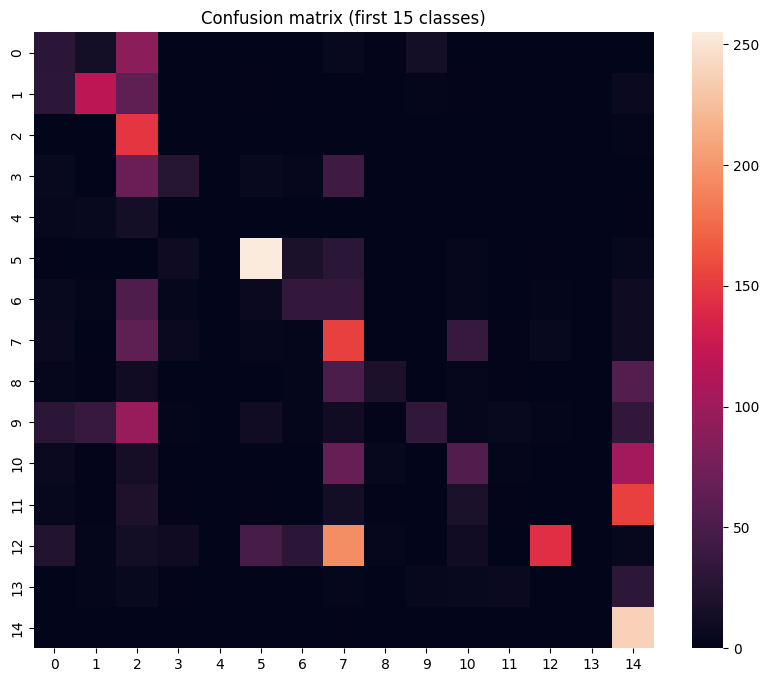

In [26]:
# === Evaluation ===
val_loss, val_acc = model.evaluate(val_gen)
print(f'Validation accuracy: {val_acc:.4f}')

val_gen.reset()
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen, verbose=1), axis=1)

print('\nClassification Report:\n')
print(classification_report(y_true, y_pred, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix for up to 15 classes
N = min(15, len(class_labels))
plt.figure(figsize=(10,8))
sns.heatmap(cm[:N,:N], annot=False)
plt.title('Confusion matrix (first %d classes)' % N)
plt.show()

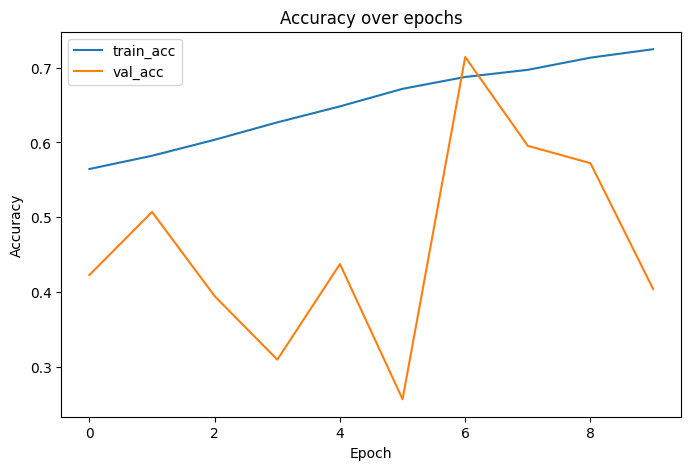

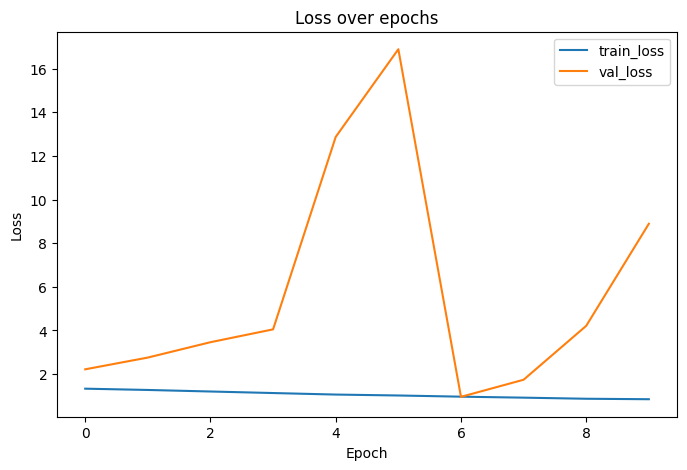

In [27]:
# === Training Curves ===
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over epochs')
plt.show()

In [28]:
# === Save final model ===
model.save('plant_disease_custom_cnn_set.keras')
print('Saved model to plant_disease_custom_cnn_subset.keras')

Saved model to plant_disease_custom_cnn_subset.keras


## Next steps & recommendations

- To further improve accuracy: increase `max_images_per_class`, increase `IMG_SIZE`, or move to transfer learning.
- Use Grad-CAM to visualize what the model focuses on for predictions.
- Consider class rebalancing or collecting more data for confused classes.

---

*End of notebook.*